In [1]:
import numpy as np 
import os 
import glob 
import torch 
import random 
import pickle 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps 
from skimage import measure, feature 
from scipy.spatial import distance 
from collections import defaultdict 
from sklearn.preprocessing import StandardScaler 
from tqdm.auto import tqdm, trange
import tifffile
from scipy.ndimage import gaussian_filter  
import sys 
from stedfm import get_pretrained_model_v2 
sys.path.insert(0, "../")
from attribute_datasets import ALSDataset 
from wavelet import detect_spots
from scipy.spatial.distance import cdist 


PIXELSIZE = 0.015
CHANNEL = "PSD95"
YOUNG_DIV = "7"


/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Debugging

In [2]:


# split = "train"
# dataset = ALSDataset(
#     tarpath=f"/home-local/Frederic/Datasets/ALS/ALS_JM_Fred_unmixed/PLKO-262-{CHANNEL}-{split}.tar",
# )

# def denormalize(img: np.ndarray, m: float, M: float) -> np.ndarray:
#     img = img * (M - m) + m
#     return img

# def show_masks(dataset):
#     indices = np.arange(len(dataset))
#     np.random.shuffle(indices)
#     for i in range(50):
#         idx = indices[i]
#         img, metadata = dataset[idx]
#         div, dpi = metadata["label"], metadata["dpi"]
#         if "5" in div and "4" in dpi:
#             label = "young"
#         elif "14" in div and "11" in dpi:
#             label = "old"
#         else:
#             continue
#         # label = metadata["label"]
#         img = img.squeeze().numpy() 
#         min_value, max_value = metadata["min_value"], metadata["max_value"]
#         mask_before = detect_spots(img)
#         mask_after = mask_before.copy()
#         mask_label, num_proteins = measure.label(mask_before, return_num=True) 
#         mask_rprops = measure.regionprops(mask_label, intensity_image=img) 
#         for prop in mask_rprops:
#             intensity = prop.mean_intensity 
#             lab = prop.label
#             if intensity < 0.09:
#                 # print(f"Removing protein {lab} with intensity {intensity}")
#                 temp_mask = mask_label == lab  
#                 mask_after[temp_mask] = 0


#         fg_intensity = np.mean(img[mask_before])
#         fig, axs = plt.subplots(1,3, figsize=(7, 5))
#         axs[0].imshow(img, cmap="hot", vmin=0, vmax=1)
#         axs[0].axis("off")
#         axs[0].set_title(f"Label: {label}")
#         axs[1].set_title(f"FG intensity: {fg_intensity:.4f}")
#         axs[1].imshow(mask_before, cmap="gray")
#         axs[2].imshow(mask_after, cmap="gray")
#         axs[1].axis("off")
#         axs[2].axis("off")
#         plt.show()
        

# def get_features(dataset, split: str = "train"):
#     div5_features, div14_features = [], []
#     all_NNs = []
#     for i in range(len(dataset)):
#         img, metadata = dataset[i]
#         temp_img = img.squeeze().detach().cpu().numpy()
#         mask = detect_spots(temp_img)
#         mask_after = mask.copy()
#         fg_intensity = np.mean(temp_img[mask])
#         if fg_intensity < 0.15:
#             # print(f"Skipping {i} because foreground intensity is too low: {fg_intensity}")
#             continue
#         label = metadata["label"]
#         div, dpi = metadata["label"], metadata["dpi"]
#         if "5" in div and "4" in dpi:
#             label = "young"
#         elif "14" in div and "11" in dpi:
#             label = "old"
#         else:
#             continue
#         min_value, max_value = metadata["min_value"], metadata["max_value"]
#         img = img.squeeze().numpy()
#         img = denormalize(img, min_value, max_value)
#         mask = detect_spots(img)
#         mask_label, num_proteins = measure.label(mask, return_num=True)
#         props = measure.regionprops(mask_label, intensity_image=img) 

#         coordinates = np.array([p.weighted_centroid for p in props])

#         if len(coordinates) == 15:
#             density = 1.0
#         else:
#             distance_matrix = distance.cdist(coordinates, coordinates, metric="euclidean")
#             distance_matrix = np.sort(distance_matrix, axis=1)
#             img_density = []
#             for d in range(distance_matrix.shape[0]):
#                 num_neighbors = np.sum(distance_matrix[d] < 50)
#                 img_density.append(num_neighbors)
#             density = np.mean(img_density)

#         features = []
#         for i, prop in enumerate(props):
#             intensity = prop.mean_intensity
#             features = []
#             if intensity < 0.09:
#                 continue
#             features.append([prop.area, prop.perimeter, prop.mean_intensity, prop.eccentricity, prop.solidity])
            
#             coords = np.array(prop.weighted_centroid)
#             distances = cdist(coords.reshape(1, -1), coordinates)
#             distances = np.sort(distances)
#             if distances.shape[1] == 1:
#                 nn_dist = 224.0
#                 # features[-1].append(nn_dist)
#             else:
#                 nn_dist = distances[:, 1] # omitting itself
#                 all_NNs.append(nn_dist.item())
#                 # features[-1].append(nn_dist.item())

#         features = np.array(features)
#         mean_features = np.mean(features, axis=0)
#         mean_features = np.r_[mean_features, num_proteins, density]
#         if label == "young":
#             div5_features.append(mean_features)
#         else:
#             div14_features.append(mean_features)
    
#     div5_features = np.array(div5_features)
#     div14_features = np.array(div14_features)
#     print(div5_features.shape, div14_features.shape)
    
#     fig, axs = plt.subplots(2, 4, figsize=(10, 5))
#     for i, f in enumerate(["area", "perimeter", "mean_intensity", "eccentricity", "solidity", "num_proteins", "density"]):
#         data = [ary[:, i] for ary in [div14_features, div5_features]]
#         ax = axs.ravel()[i]
#         parts = ax.violinplot(data, positions=[1.0, 1.6], showmeans=True)
#         for i, pc in enumerate(parts['bodies']):
#             color = "fuchsia" if i == 0 else "dodgerblue"
#             pc.set_facecolor(color)
#             pc.set_edgecolor('black')
#             pc.set_linewidth(1.5)
#         parts['cmeans'].set_color('black')
#         parts['cmeans'].set_color('black')
#         parts['cbars'].set_color('black')
#         parts['cmins'].set_color('black')
#         parts['cmaxes'].set_color('black')  
#         ax.set_ylabel(f)
#         ax.set_xticks([1.0, 1.6], ["old", "young"])
#     plt.show()
#     return all_NNs
#     # fig.savefig(f"./als-experiment/{CHANNEL}/{split}-features.pdf")

# def display_random_images(dataset, num_images=25, label: str = "old"):
#     indices = np.arange(len(dataset))
#     np.random.shuffle(indices)
#     fig, axs = plt.subplots(5,5, figsize=(20, 20))
#     counter = 0
#     class_images = 0
#     for i, idx in enumerate(indices):
#         img, metadata = dataset[indices[i]]
#         temp_img = img.squeeze().detach().cpu().numpy()
#         mask = detect_spots(temp_img)
#         fg_intensity = np.mean(temp_img[mask])
#         if fg_intensity < 0.15:
#             #print(f"Skipping {i} because foreground intensity is too low: {fg_intensity}")
#             continue
#         div, dpi = metadata["label"], metadata["dpi"]
#         if "5" in div and "4" in dpi:
#             tmp_label = "young"
#         elif "14" in div and "11" in dpi:
#             tmp_label = "old"
#         else:
#             continue
#         if tmp_label != label:
#             continue
#         class_images += 1
#         if counter >= num_images:
#             continue
#         ax = axs.ravel()[counter]
#         img = img.squeeze().numpy()
#         ax.imshow(img, cmap="hot", vmin=0, vmax=1)
#         ax.set_title(f"FG intensity: {fg_intensity:.4f}")
#         ax.axis("off")
#         counter += 1
#     print(f"[---] Displaying {num_images} random images of label {label} [---] (total: {class_images})")
#     plt.show()


# # show_masks(dataset)
# display_random_images(dataset, num_images=25, label="young")
# display_random_images(dataset, num_images=25, label="old")
        



In [3]:
# MAX_NN = np.quantile(all_NNs, q=0.75)
MAX_NN = 30.0

In [4]:
latent_encoder, model_config = get_pretrained_model_v2(
    name="mae-lightning-small",
    weights="MAE_SMALL_STED",
    path=None, 
    mask_ratio=0.0,
    pretrained=False,
    in_channels=1,
    as_classifier=True,
    blocks="all",
    num_classes=4,
)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_encoder.to(DEVICE)
latent_encoder.eval()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


In [5]:
def load_files(path, exclude=None, include=None):
    files = glob.glob(path)
    files.sort()
    if exclude is not None:
        files = [f for f in files if not any([f"_{e}_" in f for e in exclude])]
    if include is not None:
        files = [f for f in files if any([f"_{i}_" in f for i in include])]
    print(len(files))
    files = [f for f in files if os.path.basename(f).split("_")[-2] != "0"]
    print(len(files))
    return files

def load_svm():
    with open(f"./als-experiment/boundaries/MAE_SMALL_STED_als_svm_{CHANNEL}.pkl", "rb") as f:
        return pickle.load(f)

def extract_features(file, max_nn=224.0, show=False):

    if isinstance(file, str):
        image = tifffile.imread(file)
    else:
        image = file

    filtered_image = gaussian_filter(image, sigma=1.0)

    # mask = detect_spots(image, J_list=[2, 3], scale_threshold=5.0)
    mask = detect_spots(image, J_list=[3, 4], scale_threshold=2.0)

    # foreground = np.count_nonzero(mask)
    # pixels = image.shape[0] * image.shape[1]
    # ratio = foreground / pixels 
    # if ratio < 0.05:
    #     return None

    if show:    
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(image, cmap='gray')
        axes[1].imshow(mask, cmap='gray')
        plt.show()

    mask_label, num_proteins = measure.label(mask, return_num=True)

    props = measure.regionprops(mask_label, intensity_image=image)
    filtered_props = [] 
    for p in props:
        if p.mean_intensity >= 0.09:
            filtered_props.append(p)
    # print(f"Removed {len(props) - len(filtered_props)} proteins")
    props = filtered_props
    coordinates = np.array([p.weighted_centroid for p in props])

    distances = distance.pdist(coordinates) * PIXELSIZE
    distances = distance.squareform(distances)

    if len(distances) <= 1:
        nn_distances = [max_nn]
    else:
        nn_distances = np.sort(distances, axis=1)[:, 1]
        nn_distances = np.clip(nn_distances, 0, max_nn)

    image_density = num_proteins / (image.shape[0] * image.shape[1] * PIXELSIZE**2)
    density_proteins = (np.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2

    features = []
    counter = 0

    for prop, density, nn in zip(props, density_proteins, nn_distances):
        if np.isnan(nn):
            nn = 30.0

        # img = prop.intensity_image
        slc = prop.slice
        img = filtered_image[slc]
        label = prop.image

        min_distance = int(0.08 / PIXELSIZE) // 2 + 1 # in pixels
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False, labels=label)

        if show:
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(img, cmap='gray')
            axes[0].plot(peaks[:, 1], peaks[:, 0], 'r.')
            axes[1].imshow(label, cmap='gray')
            plt.show()

        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.solidity,
            density,
            # nn,
            len(peaks)
        ])

        # counter += 1
        # if counter > 5:
        #     break

    return np.array(features)

def extract_deep_features(file, show=False):

    if isinstance(file, str):
        image = tifffile.imread(file)
    else: 
        image = file
    
    X = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
    if torch.cuda.is_available():
        X = X.cuda()
    with torch.no_grad():
        latent = latent_encoder.forward_features(X)
        latent = latent.cpu().numpy().flatten()
    return latent
    
def gen_trajectory(files, per_protein=False, max_nn=224.0, extract_deep=False, timestep_idx:int = -1):
    trajectories = defaultdict(list)
    print(f"Processing {len(files)} files")
    for file in files:
        name = os.path.basename(file).split('.')[0].split("_")[-4]
        trajectories[name].append(file)
    for name, files in tqdm(trajectories.items(), desc="Loading trajectories"):

        files = list(sorted(files, key=lambda x: int(os.path.basename(x).split('.')[0].split("_")[-1])))

        timesteps, features, deep_features = [], [], []
        counter = 0
        for file in files:
            
            if extract_deep:
                deep_feature = extract_deep_features(file)
                deep_features.append(deep_feature)

            feature_per_image = extract_features(file, max_nn=max_nn, show=False)
            if feature_per_image is None:
                continue
            avg_feature = np.mean(feature_per_image, axis=0)
            std_feature = np.std(feature_per_image, axis=0)

            if per_protein:
                timesteps.extend([int(os.path.basename(file).split('.')[0].split("_")[timestep_idx])] * len(feature_per_image))
                features.extend(feature_per_image)
            else:
                timesteps.append(int(os.path.basename(file).split('.')[0].split("_")[timestep_idx]))
                # features.append(
                #     np.concatenate([avg_feature, std_feature])
                # )
                features.append(
                    avg_feature
                )

        yield name, np.array(deep_features), np.array(features), np.array(timesteps)

def get_trajectory_endpoints(files, start_idx, end_idx, model):
    embeddings, labels = [], []
    for file in files:
        fname = os.path.basename(file)
        step = fname.split(".")[0].split("_")[-1]
        if step == str(start_idx):
            pred = extract_deep_features(file)
            embeddings.append(pred)
            labels.append("1")
        elif step == str(end_idx):
            pred = extract_deep_features(file)
            embeddings.append(pred)
            labels.append("0")
        else:
            continue 

    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels




In [6]:
files = load_files(f"../als-experiment/{CHANNEL}/examples/raw-tif/*old*.tif")

print(len(files))


266
228
228


In [10]:
trajectory_id_per_condition, timesteps_per_condition, deep_trajectories_per_condition, trajectories_per_condition = [], [], [], []

for name, deep_features, features, steps in gen_trajectory(files, per_protein=False, max_nn=MAX_NN,extract_deep=True, timestep_idx=-2):
    trajectory_id_per_condition.extend([name] * len(steps))
    timesteps_per_condition.extend(steps)
    trajectories_per_condition.append(features)
    deep_trajectories_per_condition.append(deep_features)

print(np.unique(timesteps_per_condition, return_counts=True))
print(np.unique(trajectory_id_per_condition, return_counts=True))


Processing 228 files


Loading trajectories: 100%|██████████| 38/38 [00:06<00:00,  5.96it/s]

(array([1, 2, 3, 4, 5, 6]), array([38, 38, 38, 38, 38, 38]))
(array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '4',
       '5', '6', '7', '8', '9'], dtype='<U2'), array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]))


In [14]:
dataset_train = ALSDataset(
    tarpath="/home-local/Frederic/Datasets/ALS/ALS_JM_Fred_unmixed/PLKO-262-PSD95-train.tar"
)
dataset_valid = ALSDataset(
    tarpath="/home-local/Frederic/Datasets/ALS/ALS_JM_Fred_unmixed/PLKO-262-PSD95-valid.tar"
)
dataset_test = ALSDataset(
    tarpath="/home-local/Frederic/Datasets/ALS/ALS_JM_Fred_unmixed/PLKO-262-PSD95-test.tar"
)
print(len(dataset_train), len(dataset_valid), len(dataset_test))

def get_label(div, dpi):
    # if "5" in div and dpi == "4DPI":
    #     return 5
    if "5" in div and dpi == "7DPI":
        return 0
    elif "5" in div and dpi == "11DPI":
        return 1 
    elif "14" in div and dpi == "4DPI":
        return 2
    elif "14" in div and dpi == "7DPI":
        return 3 
    elif "14" in div and dpi == "11DPI":
        return 4
    else:
        return None

def gen_real_trajectory(dataset, model, extract_deep=True):
    timesteps, features, deep_features = [], [], []
    for i in trange(len(dataset)):
        img, metadata = dataset[i]
        img = img.squeeze().numpy()
        mask = detect_spots(img)
        fg_intensity = np.mean(img[mask])
        if fg_intensity < 0.15:
            continue
        div, dpi = metadata["label"], metadata["dpi"]
        label = get_label(div=div, dpi=dpi)
        if label is None:
            continue
        timesteps.append(label)

        f = extract_features(file=img)
        deep_f = extract_deep_features(file=img)
        f = np.mean(f, axis=0)
        features.append(f)
        deep_features.append(deep_f)

    timesteps = np.array(timesteps)
    features = np.array(features)
    deep_features = np.array(deep_features)
    return timesteps, features, deep_features

1430 517 486


In [15]:
timesteps_real_train, features_real_train, deep_features_real_train = gen_real_trajectory(dataset=dataset_train, model=latent_encoder)
timesteps_real_valid, features_real_valid, deep_features_real_valid = gen_real_trajectory(dataset=dataset_valid, model=latent_encoder)
timesteps_real_test, features_real_test, deep_features_real_test = gen_real_trajectory(dataset=dataset_test, model=latent_encoder)
timesteps_real = np.concatenate([timesteps_real_train, timesteps_real_valid])

100%|██████████| 486/486 [00:20<00:00, 23.63it/s]


In [16]:
features_real = np.concatenate([features_real_train, features_real_valid])
deep_features_real = np.concatenate([deep_features_real_train, deep_features_real_valid])

print(timesteps_real.shape, features_real.shape, deep_features_real.shape)
print(np.unique(timesteps_real, return_counts=True))
print(np.unique(timesteps_per_condition, return_counts=True))
timesteps_per_condition = [item - 1 for item in timesteps_per_condition]

(1421,) (1421, 7) (1421, 384)
(array([0, 1, 2, 3, 4]), array([177, 319, 262, 330, 333]))
(array([1, 2, 3, 4, 5, 6]), array([38, 38, 38, 38, 38, 38]))


## Scatter plots

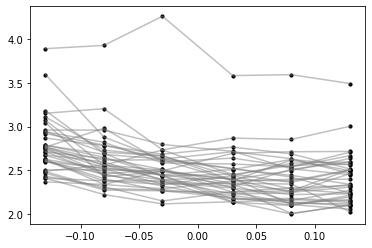

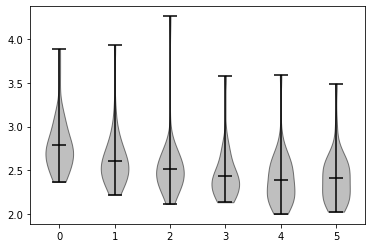

In [90]:
from scipy.spatial.distance import cdist
target_avg_feature = deep_features_real[timesteps_real == 4]
timesteps_gen = [item - 1 for item in timesteps_per_condition]

trajectories = np.concatenate(deep_trajectories_per_condition, axis=0)
trajectory_id = np.array(trajectory_id_per_condition)
# print(trajectory_id.shape, trajectories.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
uniques = list(set(trajectory_id_per_condition))
# print(np.unique(trajectory_id_per_condition))
violins = [[], [], [], [], [], []]
for i, t_id in enumerate(uniques):

    mask = trajectory_id == t_id
    data = trajectories[mask]
    
    distances_to_target = []
    for i in range(data.shape[0]):
        vector = data[i][np.newaxis, ...] 
        d = np.mean(cdist(vector, target_avg_feature, metric="euclidean"))
        distances_to_target.append(d)
        violins[i].append(d)
    
    color = 'dodgerblue' if distances_to_target[0] > distances_to_target[-1] else 'fuchsia'
    ax.plot([-0.13, -0.08, -0.03, 0.03, 0.08, 0.13], distances_to_target, color="grey", alpha=0.5)
    ax.scatter([-0.13, -0.08, -0.03, 0.03, 0.08, 0.13], distances_to_target, color="black", s=10)
plt.show()
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111)
elements = ax.violinplot(violins, positions=[0, 1, 2, 3, 4, 5], showmeans=True)
for element in elements['bodies']:
    element.set_edgecolor('black')
    element.set_facecolor('grey')
    element.set_alpha(0.5)
elements['cmeans'].set_edgecolor('black')
elements["cbars"].set_edgecolor('black')
elements["cmaxes"].set_edgecolor('black')
elements["cmins"].set_edgecolor('black')
elements["cmaxes"].set_edgecolor('black')
elements["cmins"].set_edgecolor('black')

plt.show()
plt.close(fig)




## KNN classification of trajectories & DIVs

In [11]:
# deep_features_gen = np.concatenate(deep_trajectories_per_condition, axis=0)
features_gen = np.concatenate(trajectories_per_condition, axis=0)
print(deep_features_gen.shape, len(timesteps_per_condition))
print(np.unique(timesteps_per_condition, return_counts=True))
print(np.unique(timesteps_real, return_counts=True))

(228, 384) 228
(array([1, 2, 3, 4, 5, 6]), array([38, 38, 38, 38, 38, 38]))
(array([0, 1, 2, 3, 4]), array([177, 319, 262, 330, 333]))


[0 1 2 3 4] [0 1 2 3 4]
[0 1 2 3 4] [0 1 2 3 4]



[0 1 2 3 4]
(5, 5)


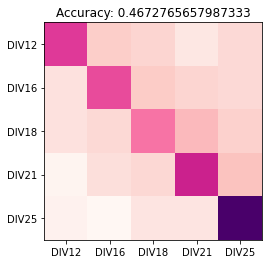

[1 2 3 4 5 6] [1 2 3 4 5 6]
[0 1 2 3 4 5] [0 1 2 3 4 5]



[0 1 2 3 4 5]
(6, 6)


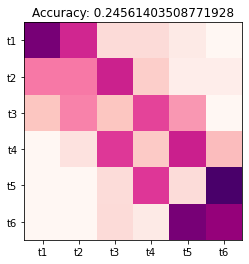

[0 1 2 3 4] [1 2 3 4 5 6]
[0 1 2 3 4] [0 1 2 3 4 5]



[0 1 2 3 4]
(5, 6)


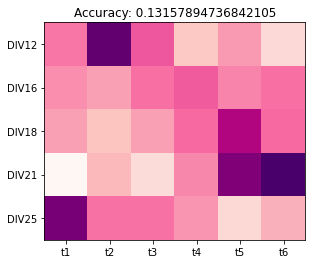

[1 2 3 4 5 6] [0 1 2 3 4]
[0 1 2 3 4 5] [0 1 2 3 4]



[0 1 2 3 4 5]
(6, 5)


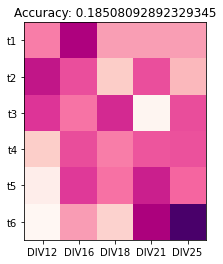

In [12]:
from scipy.spatial.distance import cdist
from numpy.linalg import norm

def knn_classification(preds: np.ndarray, targets: np.ndarray, pred_labels: np.ndarray, target_labels: np.ndarray, n_neighbors: int = 5, **kwargs):
    predlabels = kwargs.get("predlabels", None)
    targetlabels = kwargs.get("targetlabels", None)
    if isinstance(pred_labels, list):
        pred_labels = np.array(pred_labels)
    if isinstance(target_labels, list):
        target_labels = np.array(target_labels)
    
    unique_pred_labels = np.unique(pred_labels).astype(np.int8)
    unique_target_labels = np.unique(target_labels).astype(np.int8)
    print(unique_pred_labels, unique_target_labels)
    if np.min(unique_pred_labels) != 0:
        pred_labels = pred_labels - np.min(unique_pred_labels)
    if np.min(unique_target_labels) != 0:
        target_labels = target_labels - np.min(unique_target_labels)

    unique_pred_labels = np.unique(pred_labels).astype(np.int8)
    unique_target_labels = np.unique(target_labels).astype(np.int8)

    print(unique_pred_labels, unique_target_labels)
    print("\n\n")
    confusion_matrix = np.zeros((len(unique_pred_labels), len(unique_target_labels)))
    # for i in trange(5, n_neighbors):
    pdistances = cdist(preds, targets, metric="cosine").T 
    neighbor_indices = np.argsort(pdistances, axis=1)
    neighbors = neighbor_indices[:, 1:n_neighbors+1] if predlabels == targetlabels else neighbor_indices[:, :n_neighbors]
    associated_labels = pred_labels[neighbors]
    print(np.unique(associated_labels))
    print(confusion_matrix.shape)
    
    for neighbor_labels, truth in zip(associated_labels, target_labels):
        votes, vote_counts = np.unique(neighbor_labels, return_counts=True)
        max_idx = np.argmax(vote_counts)
        max_vote = votes[max_idx]
        vote_count = vote_counts[max_idx]
        if vote_count > 1:
            confusion_matrix[max_vote, truth] += 1 

    # confusion_matrix = confusion_matrix / (n_neighbors - 5)
    accuracy = np.diag(confusion_matrix).sum() / target_labels.shape[0]

    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    confusion_matrix = np.divide(confusion_matrix, row_sums, where=row_sums != 0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(confusion_matrix, cmap="RdPu")
    ax.set_xticks(np.arange(len(unique_target_labels)))
    ax.set_yticks(np.arange(len(unique_pred_labels)))
    ax.set_xticklabels(kwargs.get("predlabels", unique_target_labels))
    ax.set_yticklabels(kwargs.get("targetlabels", unique_pred_labels))
    ax.set_title(f"Accuracy: {accuracy}")
    plt.show()
    fig.savefig(f"./confusion_matrix_{kwargs.get('savename', '')}.pdf", bbox_inches="tight")
    plt.close(fig)

real_ticklabels = ["DIV25", "DIV21", "DIV18", "DIV16", "DIV12"][::-1] #, "DIV9"]
gen_ticklabels = ["t1", "t2", "t3", "t4", "t5", "t6"]# ["A", "1", "2", "3", "4", "5"]

n_neighbors = 15
knn_classification(
    preds=deep_features_real, 
    targets=deep_features_real, 
    pred_labels=timesteps_real, 
    target_labels=timesteps_real,
    n_neighbors=n_neighbors,
    predlabels=real_ticklabels,
    targetlabels=real_ticklabels,
    savename="DIV-to-DIV"
    )
knn_classification(
    preds=deep_features_gen, 
    targets=deep_features_gen, 
    pred_labels=timesteps_per_condition, 
    target_labels=timesteps_per_condition,
    n_neighbors=n_neighbors,
    predlabels=gen_ticklabels,
    targetlabels=gen_ticklabels,
    savename="timestep-to-timestep"

    )
knn_classification(
    preds=deep_features_real, 
    targets=deep_features_gen, 
    pred_labels=timesteps_real, 
    target_labels=timesteps_per_condition,
    n_neighbors=n_neighbors,
    predlabels=gen_ticklabels,
    targetlabels=real_ticklabels,
    savename="DIV-to-timestep"
    )
knn_classification(
    preds=deep_features_gen, 
    targets=deep_features_real, 
    pred_labels=timesteps_per_condition, 
    target_labels=timesteps_real,
    n_neighbors=n_neighbors,
    predlabels=real_ticklabels,
    targetlabels=gen_ticklabels,
    savename="timestep-to-DIV"
    )


## Trajectories

In [32]:
from tqdm import trange

class FoldChangeScaler:
    def __init__(self, trajectory_id, index=0):
        self.index = index

        self.baseline = None

    def fit_transform(self, X, trajectory_id=None):
        if trajectory_id is None:
            baselines = X[:, [self.index]]
            self.baseline = np.mean(baselines, axis=0, keepdims=True)

            return (X - baselines) / baselines

        X = X.copy()
        baselines = []
        for trajectory in set(trajectory_id):
            mask = trajectory_id == trajectory
            baseline = X[mask][[self.index], :]
            baselines.append(baseline)
        baseline = np.mean(baselines, axis=0)
        # X = np.log2(X + 1) - np.log2(baseline + 1)
        X = (X - baseline) / baseline
        # X[mask] = (X[mask] - baseline) / baseline
        return X

# Generate bootstrap trajectories
def bootstrap(samples, trajectories, n=1000):
    out = []
    for _ in trange(n):
        items = np.random.choice(samples, len(samples))
        bootstrap_sample = []
        for item in items:
            mask = trajectory_id == item
            bootstrap_sample.append(trajectories[mask])
        mean = np.mean(bootstrap_sample, axis=0)
        out.append(mean)
    out = np.array(out)
    return out

def get_confidence_interval(bootstrapped_trajectory, indices, axis=0):
    temp = np.take(bootstrapped_trajectory, indices, axis=axis)
    mean, cid, ciu = np.percentile(np.take(bootstrapped_trajectory, indices, axis=axis), [50, 5.0, 95], axis=0) 
    return mean, cid, ciu   

def from_categorical(names):
    unique_names = list(sorted(set(names)))
    return np.array([unique_names.index(name) for name in names])

def convert_timesteps(timesteps, invert=False):
    unique_timesteps = list(sorted(set(timesteps)))
    return np.array([
        max(unique_timesteps) - unique_timesteps.index(t) if invert else unique_timesteps.index(t) for t in timesteps])

def get_mask_real_images(timesteps):
    return np.array([t == 0 for t in timesteps])

In [33]:
scaled_trajectories = [] 
# standard_scaler = StandardScaler() 

trajectories = np.concatenate(trajectories_per_condition, axis=0)
trajectories_ = trajectories.copy()
trajectory_id = np.array(trajectory_id_per_condition)

# standard_scaler.fit(trajectories) 
scaler = FoldChangeScaler(trajectory_id, index=0)
trajectories = scaler.fit_transform(trajectories, trajectory_id=trajectory_id)
print(trajectories.shape, trajectory_id.shape)


bootstrapped_trajectory = bootstrap(list(set(trajectory_id)), trajectories=trajectories, n=1000)
print(bootstrapped_trajectory.shape)

(228, 7) (228,)


100%|██████████| 1000/1000 [00:00<00:00, 5036.61it/s]

(1000, 6, 7)


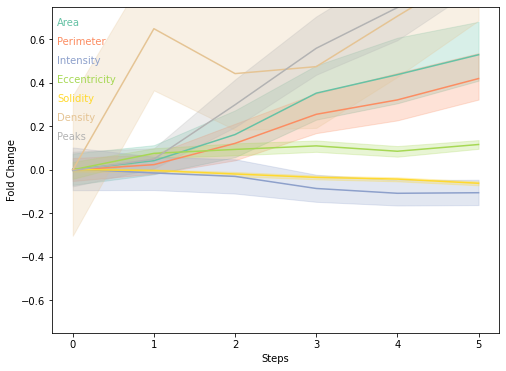

In [34]:
FEATURES = ["Area", "Perimeter", "Intensity", "Eccentricity", "Solidity", "Density", "Peaks"]
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap("Set2", bootstrapped_trajectory.shape[-1])
for t in range(bootstrapped_trajectory.shape[-1]):
    mean, cid, ciu = get_confidence_interval(bootstrapped_trajectory, t, axis=-1)
    ax.plot(mean, color=cmap(t))
    ax.fill_between(
        np.arange(0, bootstrapped_trajectory.shape[1], 1),
        cid, ciu, color=cmap(t), alpha=0.25
    )
    ax.annotate(
            FEATURES[t],
            xy=(0.01, 1 - 0.35 * (t + 1)/bootstrapped_trajectory.shape[1]), color=cmap(t),
            xycoords='axes fraction',
            horizontalalignment='left'
        )
# ax.annotate(
#         condition,
#         xy=(0.99, 0.99),
#         xycoords='axes fraction',
#         horizontalalignment='right',
#         verticalalignment='top'
#     )
ax.set(
    ylim=(-0.75, 0.75), ylabel="Fold Change", xlabel="Steps"
)
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/trajectory_bootstrap.pdf", bbox_inches="tight")

## Average 'trajectories'

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


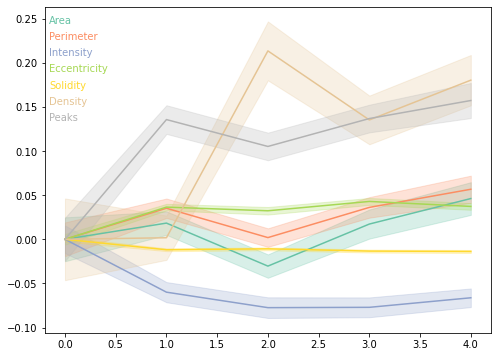

In [35]:
from scipy import stats

FEATURES = ["Area", "Perimeter", "Intensity", "Eccentricity", "Solidity", "Density", "Peaks"]
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap("Set2", bootstrapped_trajectory.shape[-1])
baseline = np.zeros((1, 7))

for f, feature_name in enumerate(FEATURES):
    feature_trajectory = []
    feature_errors = [] 
    for t, tstep in enumerate([5, 4, 3, 2, 1, 0][::-1]):
        mask = np.where(timesteps_real == tstep)[0]
        feature = features_real[mask, :]
        feat = feature[:, f]
        mean_f = np.mean(feat)
        if t == 0:
            baseline[:, f] = mean_f
        foldchange = (feat - baseline[:, f]) / baseline[:, f]
        mean_foldchange = np.mean(foldchange)
        sem = stats.sem(foldchange) 
        feature_trajectory.append(mean_foldchange)
        feature_errors.append(sem)


    feature_trajectory = np.array(feature_trajectory)
    feature_errors = np.array(feature_errors)
    ax.plot(feature_trajectory, color=cmap(f))
    ax.annotate(
            FEATURES[f],
            xy=(0.01, 1 - 0.35 * (f + 1)/baseline.shape[1]), color=cmap(f),
            xycoords='axes fraction',
            horizontalalignment='left'
        )
    ax.fill_between(np.arange(0, feature_trajectory.shape[0], 1), feature_trajectory - feature_errors, feature_trajectory + feature_errors, color=cmap(f), alpha=0.25)
plt.show()


        


## Real 'trajectories'

Feature Area
Feature Perimeter
Feature Intensity
Feature Eccentricity
Feature Solidity
Feature Density


<ipython-input-39-e9e0d6feca88>:33: RuntimeWarning: invalid value encountered in scalar divide
  foldchange = (feature - baseline) / baseline
<ipython-input-39-e9e0d6feca88>:33: RuntimeWarning: divide by zero encountered in scalar divide
  foldchange = (feature - baseline) / baseline


Feature Peaks


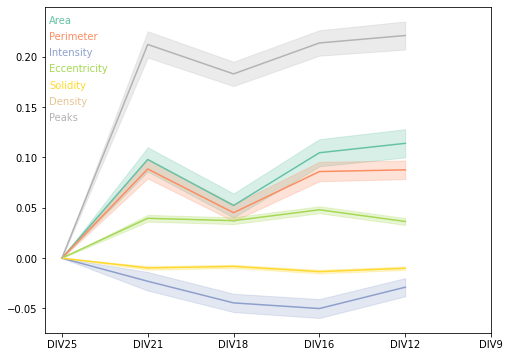

In [39]:
from scipy import stats
real_trajectories = [] 
real_trajectories_ids = []

# print(np.unique(timesteps))
def real_bootstrap(trajectories, n=1000):
    out = []
    for _ in trange(n):
        mean = np.mean(trajectories, axis=0)
        out.append(mean)
    out = np.array(out)
    return out


fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap("Set2", bootstrapped_trajectory.shape[-1])


for f, feature_name in enumerate(FEATURES):
    print(f"Feature {feature_name}")
    feature_trajectories = []
    for rep in range(1000):
        traj = []
        baseline = None
        for t, tstep in enumerate([0, 1, 2, 3, 4]):
            mask = np.where(timesteps_real == tstep)[0]
            feature = features_real[mask, :]
            n = feature.shape[0]
            i = np.random.randint(n)
            feature = feature[i, f]
            if t == 0:
                baseline = feature
            foldchange = (feature - baseline) / baseline
            traj.append(foldchange)
        feature_trajectories.append(np.array(traj))

    feature_trajectories = np.array(feature_trajectories)
    mean = np.mean(feature_trajectories, axis=0) 
    sem = stats.sem(feature_trajectories, axis=0)
    ax.plot(mean, color=cmap(f))
    ax.annotate(
            FEATURES[f],
            xy=(0.01, 1 - 0.35 * (f + 1)/7), color=cmap(f),
            xycoords='axes fraction',
            horizontalalignment='left'
        )
    ax.fill_between(np.arange(0, 5, 1), mean - sem, mean + sem, color=cmap(f), alpha=0.25)
ax.set_xticks(np.arange(0, 6, 1))
ax.set_xticklabels(["DIV25", "DIV21", "DIV18", "DIV16", "DIV12", "DIV9"])
plt.show()
fig.savefig("./real_trajectories.pdf", transparent=True, bbox_inches="tight")
    
        


### Deep features

##### Ensemble clustering

In [65]:
from scipy.cluster import hierarchy

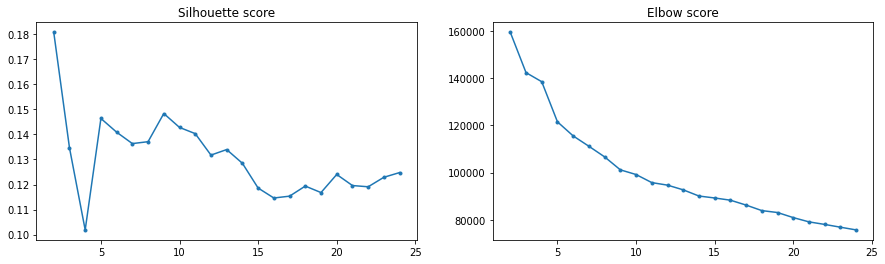

In [66]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 



deep_trajectories = np.array(deep_trajectories_per_condition)
deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

scaler = StandardScaler()
deep_trajectories = scaler.fit_transform(deep_trajectories)

unique_names = list(sorted(set(trajectory_id_per_condition)))
trajectory_id = np.array([unique_names.index(name) for name in trajectory_id_per_condition])

unique_names = list(sorted(set(timesteps_per_condition)))
timesteps = np.array([unique_names.index(name) for name in timesteps_per_condition])

# all_timesteps.extend(timesteps) # probably won't need this
# all_trajectories.extend(deep_trajectories) # probably won't need this

n_clusters = 25 
Nd = len(deep_trajectories)
cluster_matrix = np.zeros((Nd, Nd))
silhouettes, elbows = [], [] 
for n in range(2, n_clusters):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init="auto").fit(deep_trajectories)
    klabels = kmeans.labels_ 
    for j in range(Nd):
        for i in range(j, Nd):
            # if j == i:
            #     continue
            if klabels[j] == klabels[i]:
                cluster_matrix[j, i] += 1
                cluster_matrix[i, j] += 1
    
    silhouettes.append(silhouette_score(deep_trajectories, klabels, metric="euclidean"))
    elbows.append(kmeans.inertia_)
big_matrix = cluster_matrix/n_clusters 

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(np.arange(2, 2 + len(silhouettes)), silhouettes, marker='.')
axs[0].set_title("Silhouette score")
axs[1].plot(np.arange(2, 2 + len(elbows)), elbows, marker='.')
axs[1].set_title("Elbow score")
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/choosing_K.pdf", bbox_inches="tight")


##### Consensus clustering

[0, 1, 2, 3, 4, 5]
6.651435935194752
3


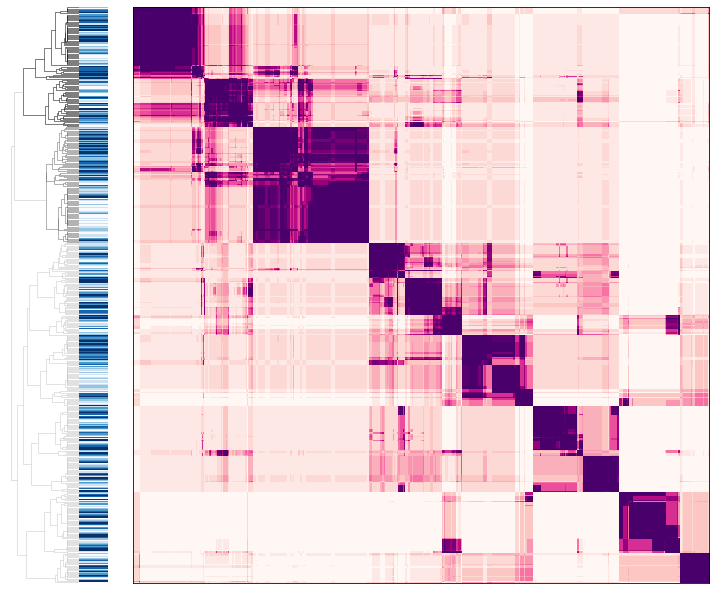

[0, 1, 2, 3, 4, 5] [1 2 3]


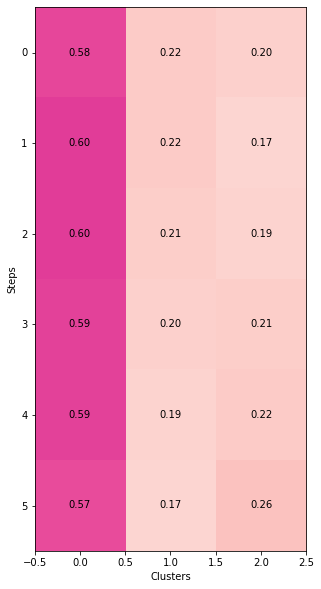

In [67]:
import matplotlib 
from scipy.spatial import distance 
from sklearn.cluster import KMeans

SCALE = 0.8 

deep_trajectories = np.array(deep_trajectories_per_condition)
deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])
scaler = StandardScaler()
deep_trajectories = scaler.fit_transform(deep_trajectories)
unique_names = list(sorted(set(timesteps_per_condition)))
print(unique_names)
timesteps = np.array([unique_names.index(name) for name in timesteps_per_condition])

D = big_matrix 
distances = distance.cdist(D, D)
mask = np.triu(np.ones_like(distances, dtype=bool)) * np.invert(np.eye(len(distances), dtype=bool))
dendrogram_distance = np.quantile(distances[mask], q=0.50)
print(dendrogram_distance)

Y = hierarchy.linkage(D, method="average", metric="euclidean")
Y2 = hierarchy.linkage(D.T, method="average", metric="euclidean")

labels = hierarchy.fcluster(Y, dendrogram_distance, "distance")
clusters_per_condition = labels
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0, 0, 0.1, SCALE])
ax1.set_xticks([])
ax1.set_yticks([])
fig.gca().invert_yaxis()
ax1.axis("off")

cmap = plt.get_cmap("Greys", (labels.max()).item() + 1)
print(labels.max())
hierarchy.set_link_color_palette([matplotlib.colors.to_hex(cmap(i+1)) for i in range(labels.max()+1)])
Z1 = hierarchy.dendrogram(
    Y,
    orientation="left",
    color_threshold=dendrogram_distance,
    above_threshold_color="silver",
    ax=ax1
)
Z2 = hierarchy.dendrogram(
    Y2,
    orientation="left",
    color_threshold=dendrogram_distance,
    above_threshold_color="silver",
    no_plot=True
)

for collection in ax1.collections:
    collection.set_linewidth(0.5)

ax2 = fig.add_axes([0.1, 0, 0.04, SCALE])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis("off")

cmap = plt.get_cmap("Blues", len(set(timesteps)))
for i, leaf in enumerate(Z1["leaves"]):
    ax2.barh(i+0.5, 1, 1.0, color=cmap(timesteps[leaf]))

ax2.set(ylim=(0, len(Z1["leaves"])), xlim=(0, 1))

axmatrix = fig.add_axes([0.15, 0, 0.85, SCALE])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1, :]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im = axmatrix.matshow(sorted_co_matrix, aspect="equal", origin="lower", cmap="RdPu", vmin=0, vmax=0.5)
axmatrix.set_xticks([])
axmatrix.set_yticks([])
fig.gca().invert_xaxis()

plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/dendrogram.pdf", bbox_inches="tight")
plt.close(fig)

uniques = np.unique(labels)

print(unique_names, uniques) 
proportions = np.zeros((len(unique_names), len(uniques)))
for i, unique in enumerate(uniques):
    mask = labels == unique 
    timestep, counts = np.unique(timesteps[mask], return_counts=True)
    for t, c in zip(timestep, counts):
        proportions[t, i] = c 

proportions = proportions / np.sum(proportions, axis=1, keepdims=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(proportions, vmin=0, vmax=1.0, cmap="RdPu")
for j in range(proportions.shape[1]):
    for i in range(proportions.shape[0]):
        ax.text(j, i, f"{proportions[i, j]:.2f}", ha="center", va="center", color="black")
ax.set(
    xlabel="Clusters", ylabel="Steps"
)
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/proportions.pdf", bbox_inches="tight")

(486, 7)
(1, 7)
Cluster 1 has 287 proteins
Cluster 2 has 98 proteins
Cluster 3 has 101 proteins


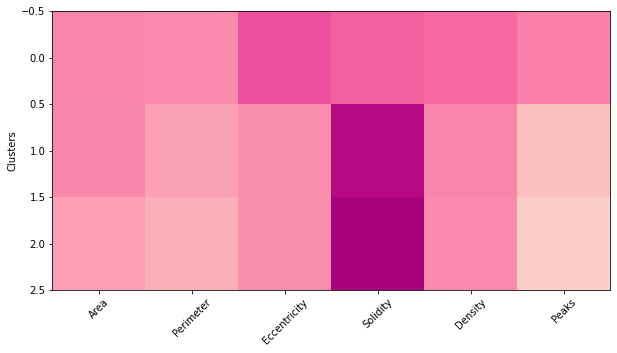

In [68]:
class MaskedMinMaxScaler:
    def __init__(self):

        self.mean = None 
        self.std = None

        self.min = None
        self.max = None

    def fit_transform(self, X, mask):
        self.fit(X, mask)
        return self.transform(X)
    
    def fit(self, X, mask):
        # self.mean = numpy.mean(X, axis=0, keepdims=True)
        # self.std = numpy.std(X, axis=0, keepdims=True)
        #self.min = np.min(X, axis=0, keepdims=True)
        self.min = np.quantile(X, q=0.05, axis=0, keepdims=True)
        # self.max = np.max(X, axis=0, keepdims=True)
        self.max = np.quantile(X, q=0.95, axis=0, keepdims=True)
        # nn_max = np.quantile(X[:, 6], q=0.95)
        # self.max[0, 6] = nn_max

        mask = np.array(mask)
        # self.mean[:, ~mask] = 0
        # self.std[:, ~mask] = 1

        self.min[:, ~mask] = 0
        self.max[:, ~mask] = 1


    def transform(self, X):
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet")
        
        print(self.min.shape)
        X = (X - self.min) / (self.max - self.min)
        return X 
    
trajectories = np.array(trajectories_per_condition)
trajectories = trajectories.reshape(-1, trajectories.shape[-1])
print(trajectories.shape)

# scaler = StandardScaler()
# trajectories = scaler.fit_transform(deep_trajectories) 


scaler = MaskedMinMaxScaler()

# trajectories = scaler.fit_transform(trajectories, [f not in ["Eccentricity", "Solidity"] for f in final_features])
trajectories = scaler.fit_transform(trajectories, [True for _ in FEATURES])


deep_trajectories = np.array(deep_trajectories_per_condition)
deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

unique_labels = np.unique(labels)
correlation_matrix = np.zeros((len(unique_labels), trajectories.shape[-1]))

for i, cluster_id in enumerate(unique_labels):
    mask = labels == cluster_id
    print(f"Cluster {cluster_id} has {np.sum(mask)} proteins")
    d_traj = deep_trajectories[mask]
    t_traj = trajectories[mask]
    for feature_idx in range(t_traj.shape[-1]):
        correlation_matrix[i, feature_idx] = np.mean(t_traj[:, feature_idx])

final_matrix = np.delete(correlation_matrix, 2, axis=1)
final_features = np.delete(FEATURES, 2)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(final_matrix, cmap="RdPu", vmin=0, vmax=1)
ax.set(ylabel="Clusters")
ax.set_xticks(np.arange(0, final_matrix.shape[-1], 1), labels=[final_features[i] for i in range(final_matrix.shape[-1])], rotation=45)
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/correlation_matrix.pdf", bbox_inches="tight")




--- Unraveling trajectory embeddings ---
(486, 384) (486,)
(1543, 384) (1543,)

--- Computing association matrix ---


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


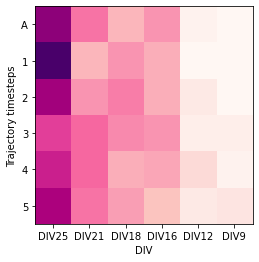

In [69]:
print("--- Unraveling trajectory embeddings ---")
unique_real = np.unique(timesteps_real)
timesteps_gen = np.array(timesteps_per_condition)
unique_gen = np.unique(timesteps_gen)
deep_features_gen = []
for i in range(len(deep_trajectories_per_condition)):
    features = deep_trajectories_per_condition[i]
    for t in range(features.shape[0]):
        t_feat = features[t]
        deep_features_gen.append(t_feat)
deep_features_gen = np.array(deep_features_gen)

print(deep_features_gen.shape, timesteps_gen.shape)
print(deep_features_real.shape, timesteps_real.shape)


print("\n--- Computing association matrix ---")
big_association_matrix = np.zeros((len(unique_gen), len(unique_real)))
num_examples_min = 122 


for _ in trange(1):

    association_matrix = np.zeros((len(unique_gen), len(unique_real)))
    for t_gen in range(len(unique_gen)):
        mask = timesteps_gen == unique_gen[t_gen]
        gen_features = deep_features_gen[mask]
        mapped_to = [0] * len(unique_real)
        for k in range(gen_features.shape[0]):
            sample = gen_features[k][np.newaxis, ...]
            distance_matrix = cdist(sample, deep_features_real, metric="cosine")[0]
            distance_ids = np.argsort(distance_matrix)[:5]
            labels = timesteps_real[distance_ids]
            votes, vote_counts = np.unique(labels, return_counts=True)
            max_idx = np.argmax(vote_counts)
            max_vote = votes[max_idx]
            mapped_to[max_vote] += 1
        mapped_to = [item / gen_features.shape[0] for item in mapped_to]
        association_matrix[t_gen] = mapped_to
    big_association_matrix += association_matrix
big_association_matrix = big_association_matrix / 1000
    


# association_matrix = association_matrix / association_matrix.sum(axis=0, keepdims=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(big_association_matrix, cmap="RdPu")
ax.set(
    yticks=range(len(unique_gen)),
    yticklabels=["A", "1", "2", "3", "4", "5"],
    ylabel="Trajectory timesteps",
    xticks=range(len(unique_real)),
    xticklabels=["DIV25", "DIV21", "DIV18", "DIV16", "DIV12", "DIV9"],
    xlabel="DIV",
)

plt.show()
fig.savefig(f"../als-experiment/{CHANNEL}/figure_panels/association_matrix.pdf", bbox_inches="tight")

    



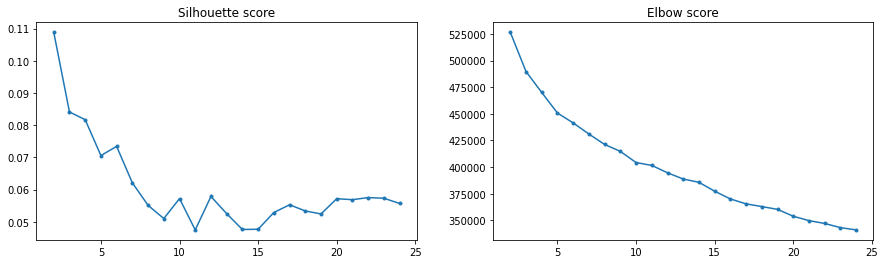

In [70]:
from sklearn.preprocessing import StandardScaler
# deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

scaler = StandardScaler()
deep_features_real = scaler.fit_transform(deep_features_real)



unique_names = list(sorted(set(timesteps_real)))
timesteps = np.array([unique_names.index(name) for name in timesteps_real])


n_clusters = 25 
Nd = len(deep_features_real)
cluster_matrix = np.zeros((Nd, Nd))
silhouettes, elbows = [], [] 
for n in range(2, n_clusters):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init="auto").fit(deep_features_real)
    klabels = kmeans.labels_ 
    for j in range(Nd):
        for i in range(j, Nd):
            # if j == i:
            #     continue
            if klabels[j] == klabels[i]:
                cluster_matrix[j, i] += 1
                cluster_matrix[i, j] += 1
    
    silhouettes.append(silhouette_score(deep_features_real, klabels, metric="euclidean"))
    elbows.append(kmeans.inertia_)
big_matrix = cluster_matrix/n_clusters 

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(np.arange(2, 2 + len(silhouettes)), silhouettes, marker='.')
axs[0].set_title("Silhouette score")
axs[1].plot(np.arange(2, 2 + len(elbows)), elbows, marker='.')
axs[1].set_title("Elbow score")
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/choosing_K.pdf", bbox_inches="tight")


9.031766161720508
4


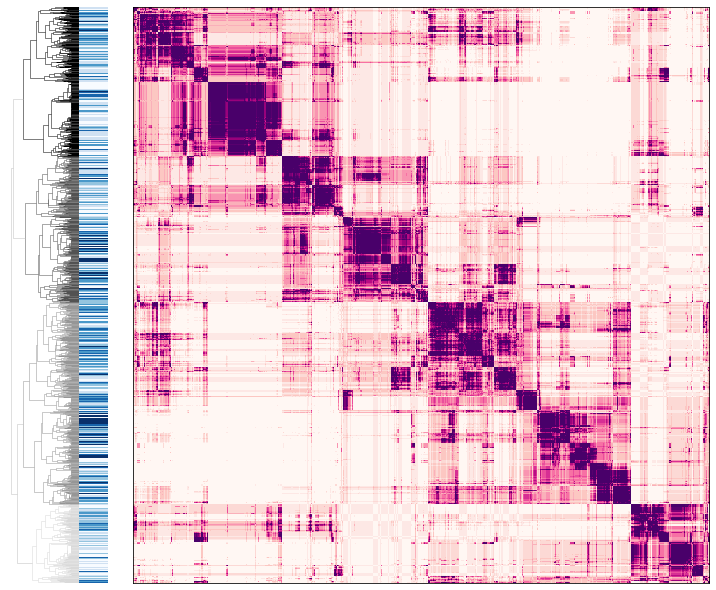

[0, 1, 2, 3, 4, 5] [1 2 3 4]


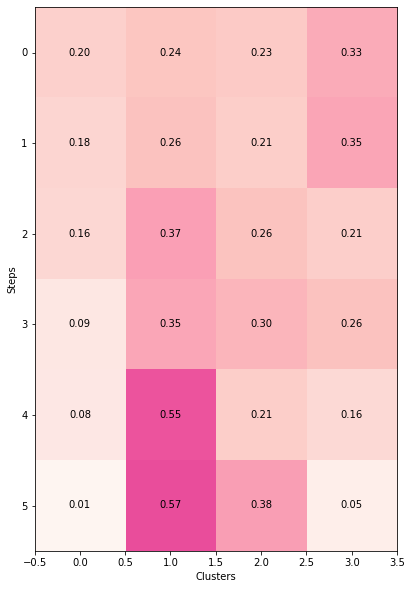

In [75]:
import matplotlib 
from scipy.spatial import distance 
from sklearn.cluster import KMeans

SCALE = 0.8 

D = big_matrix 
distances = distance.cdist(D, D)
mask = np.triu(np.ones_like(distances, dtype=bool)) * np.invert(np.eye(len(distances), dtype=bool))
dendrogram_distance = np.quantile(distances[mask], q=0.40)
print(dendrogram_distance)

Y = hierarchy.linkage(D, method="average", metric="euclidean")
Y2 = hierarchy.linkage(D.T, method="average", metric="euclidean")

labels = hierarchy.fcluster(Y, dendrogram_distance, "distance")
clusters_per_condition = labels
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0, 0, 0.1, SCALE])
ax1.set_xticks([])
ax1.set_yticks([])
fig.gca().invert_yaxis()
ax1.axis("off")

cmap = plt.get_cmap("Greys", (labels.max()).item() + 1)
print(labels.max())
hierarchy.set_link_color_palette([matplotlib.colors.to_hex(cmap(i+1)) for i in range(labels.max()+1)])
Z1 = hierarchy.dendrogram(
    Y,
    orientation="left",
    color_threshold=dendrogram_distance,
    above_threshold_color="silver",
    ax=ax1
)
Z2 = hierarchy.dendrogram(
    Y2,
    orientation="left",
    color_threshold=dendrogram_distance,
    above_threshold_color="silver",
    no_plot=True
)

for collection in ax1.collections:
    collection.set_linewidth(0.5)

ax2 = fig.add_axes([0.1, 0, 0.04, SCALE])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis("off")

cmap = plt.get_cmap("Blues", len(set(timesteps)))
for i, leaf in enumerate(Z1["leaves"]):
    ax2.barh(i+0.5, 1, 1.0, color=cmap(timesteps[leaf]))

ax2.set(ylim=(0, len(Z1["leaves"])), xlim=(0, 1))

axmatrix = fig.add_axes([0.15, 0, 0.85, SCALE])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1, :]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im = axmatrix.matshow(sorted_co_matrix, aspect="equal", origin="lower", cmap="RdPu", vmin=0, vmax=0.5)
axmatrix.set_xticks([])
axmatrix.set_yticks([])
fig.gca().invert_xaxis()

plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/dendrogram.pdf", bbox_inches="tight")
plt.close(fig)

uniques = np.unique(labels)

print(unique_names, uniques) 
proportions = np.zeros((len(unique_names), len(uniques)))
for i, unique in enumerate(uniques):
    mask = labels == unique 
    timestep, counts = np.unique(timesteps[mask], return_counts=True)
    for t, c in zip(timestep, counts):
        proportions[t, i] = c 

proportions = proportions / np.sum(proportions, axis=1, keepdims=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(proportions, vmin=0, vmax=1.0, cmap="RdPu")
for j in range(proportions.shape[1]):
    for i in range(proportions.shape[0]):
        ax.text(j, i, f"{proportions[i, j]:.2f}", ha="center", va="center", color="black")
ax.set(
    xlabel="Clusters", ylabel="Steps"
)
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/proportions.pdf", bbox_inches="tight")

(1, 7)
Cluster 1 has 211 proteins
Cluster 2 has 542 proteins
Cluster 3 has 391 proteins
Cluster 4 has 399 proteins


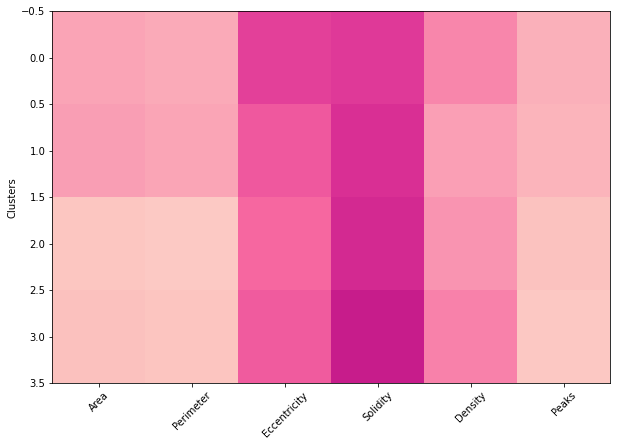

In [84]:
class MaskedMinMaxScaler:
    def __init__(self):

        self.mean = None 
        self.std = None

        self.min = None
        self.max = None

    def fit_transform(self, X, mask):
        self.fit(X, mask)
        return self.transform(X)
    
    def fit(self, X, mask):
        # self.mean = numpy.mean(X, axis=0, keepdims=True)
        # self.std = numpy.std(X, axis=0, keepdims=True)
        #self.min = np.min(X, axis=0, keepdims=True)
        self.min = np.quantile(X, q=0.01, axis=0, keepdims=True)
        # self.max = np.max(X, axis=0, keepdims=True)
        self.max = np.quantile(X, q=0.99, axis=0, keepdims=True)
        # nn_max = np.quantile(X[:, 6], q=0.95)
        # self.max[0, 6] = nn_max

        mask = np.array(mask)
        # self.mean[:, ~mask] = 0
        # self.std[:, ~mask] = 1

        self.min[:, ~mask] = 0
        self.max[:, ~mask] = 1


    def transform(self, X):
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet")
        
        print(self.min.shape)
        X = (X - self.min) / (self.max - self.min)
        return X 
    
# scaler = StandardScaler()
# trajectories = scaler.fit_transform(deep_trajectories) 


scaler = MaskedMinMaxScaler()

trajectories = scaler.fit_transform(trajectories, [f not in ["Eccentricity", "Solidity"] for f in FEATURES])
# trajectories = scaler.fit_transform(features_real, [True for _ in FEATURES])



unique_labels = np.unique(labels)
correlation_matrix = np.zeros((len(unique_labels), trajectories.shape[-1]))

for i, cluster_id in enumerate(unique_labels):
    mask = labels == cluster_id
    print(f"Cluster {cluster_id} has {np.sum(mask)} proteins")
    d_traj = deep_features_real[mask]
    t_traj = trajectories[mask]
    for feature_idx in range(t_traj.shape[-1]):
        correlation_matrix[i, feature_idx] = np.mean(t_traj[:, feature_idx])

final_matrix = np.delete(correlation_matrix, 2, axis=1)
final_features = np.delete(FEATURES, 2)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(final_matrix, cmap="RdPu", vmin=0, vmax=1)
ax.set(ylabel="Clusters")
ax.set_xticks(np.arange(0, final_matrix.shape[-1], 1), labels=[final_features[i] for i in range(final_matrix.shape[-1])], rotation=45)
plt.show()
# fig.savefig(f"./als-experiment/{CHANNEL}/figure_panels/correlation_matrix.pdf", bbox_inches="tight")


